In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import torch
import torch.nn as nn
from helper_functions_preprocessing import PreProcessor

##Pytorch Stuff:
import torch.nn.functional as F

# Sklearn Stuff
import sklearn

# Plot stuff:
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

import wandb


# DEL Mini-Challenge 1
Es sollen Immobillienobjekte klassifiziert werden. Von der FHNW haben wir einen Datensatz erhalten (Siehe beiliegendes EDA-Notebook), in denen wir vorraussagen sollen, um was für ein Wohnobjekt es sich handelt; Ist es ein Zimmer? Wohnung? Haus? Diese Challenge hatten wir gelöst, aber ohne Deep Learning. Im beiliegenden EDA-Notebook wurden die Daten sehr genau erforscht.
## Einführung
### Lösung der Mini-Challenge 1 für DEL
Wir benutzen ein Neutal-Network. Zur Erstellung wir das Deep-Learning Framework Pytorch benutzt.
### Ground Truth
Als Ground Truth bentzen wir das Modell, welches wir in der Challenge Immobillienrehcner benutzt haben. Mit diesem haben wir die Macro-F1 Score maximiert, da wir sowohl die Precision, als auch den Recall hoch haben möchten. Ebenfalls haben wir die "Macro" F1 Score optimiert, da wir eine starke Class-Imbalance haben.
### Grobübersicht Inhalt Datensatz
Es gab keine klare Beschreibung, wie gewisse Features (z.B. densities oder gde) zustande gekommen sind. Gde bezieht sich aber auf Gemeinden, in denen das Wohnobjekt liegt. Densities S bis L steht einfach für die Inensitäts des z.B. Waldes. Ist ein grosser Wald, welcher sehr dicht ist? -> ForestDensityL ist hoch. Dies wurde aber nicht zu 100% vom Challengeherausgeber bestätigt.


## Erstellung Modell Ground Truth

In [3]:
#read in data
csv_data = pd.read_csv('immo_dev_data.csv')
csv_data.head()

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0


In [4]:
csv_data.columns

Index(['Id', 'AreaLiving', 'AreaProperty', 'BuiltYear', 'FloorNumber',
       'ForestDensityL', 'ForestDensityM', 'ForestDensityS', 'GroupNameDe',
       'HouseObject', 'LastUpdate', 'Latitude', 'Locality', 'Longitude',
       'Name', 'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS', 'NoisePollutionRoadL', 'NoisePollutionRoadM',
       'NoisePollutionRoadS', 'PopulationDensityL', 'PopulationDensityM',
       'PopulationDensityS', 'RealEstateTypeId', 'Renovationyear',
       'RiversAndLakesL', 'RiversAndLakesM', 'RiversAndLakesS', 'Rooms',
       'SourceId', 'StateShort', 'StreetAndNr', 'TravelTimeMiv',
       'WorkplaceDensityL', 'WorkplaceDensityM', 'WorkplaceDensityS', 'Zip',
       'distanceToTrainStation', 'gde_area_agriculture_percentage',
       'gde_area_forest_percentage', 'gde_area_nonproductive_percentage',
       'gde_area_settlement_percentage', 'gde_average_house_hold',
       'gde_empty_apartments', 'gde_foreigners_percentage',
       'g

### Daten vorbereiten mit der Klasse PreProcessor
PreProcessor ist eine Klasse, welche ich geschrieben habe um Daten nach Standardverfahren zu preprozessieren.
Die Daten wurden folgendermassen preprozessiert:
- Onehot-Encoden: Kategorische Daten oder Strings werden Onehot-encoded. Dies bedeutet, dass ein Attribut in mehrere Attribute binär aufgeteilt wird und diese neuen Attribute sagen, ob dieser Eintrag ein String oder Kategorie enthält.
- Standardisieren auf die Z-Score: z=(x−μ)/σ​. (σ ist entweder die Standardabweichung oder das 75% Quantil subtrahiert vom 25% Quantil, falls der Robust-Scaler verwendet wird.)
- NANs auffüllen (entweder mit Mean oder Median oder mit einem bestimmten String).
- auf allen geskewten Werten eine Boxcox-Transformation durchführen, wobei dies bei unseren Test das Ergebniss nicht verbessert hat.
- 'StreetAndNr', 'LastUpdate', 'Locality', 'Id' werden gedropped; 'StreetAndNr' und 'LastUpdate' haben zuviele, einzigartige Werte und 'Locality' ist bereits im Zipcode vorhanden.
- Falls ein Attribut nur Werte zwischen 0 und 1 hat, wird ein neues Attribut kreiert, welches besagt, dass dieses Attribut 0 ist.
- Falls ein Attribut NANs hatte, wird ein neues Attribut erstellt, welches zeigt, wo ein Attribut NANs hatte.
- Wie in EDA gesehen, reicht es, wenn wir nur die ersten zwei Ziffern von der Zip benutzen. 
- Wir haben einen balancierten Train/Test-Split (alle Klassen kommen im Train/Test prozentual gleichoft vor) erzeugt.

Ebenfalls hat es 3 Reihen, welche alles NA sind. Diese kamen auch nicht im Kaggle-Datensatz vor, welches man hochladen konnte (teil der Challenge). Diese werden am Anfang also entfernt. 


In [5]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

## Drop der Säulen, welche höchstwahrscheinlich

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()

### Metriken
Wir beginnen mit 2., den Metriken. Hierfür müssen wir uns als erstes einen Überblick über unsere Zielvariable verschaffen. Schauen wir einmal, wie viele verschiedene Objekttypen es gibt und wie viele Objekte es für jeden Typen gibt.

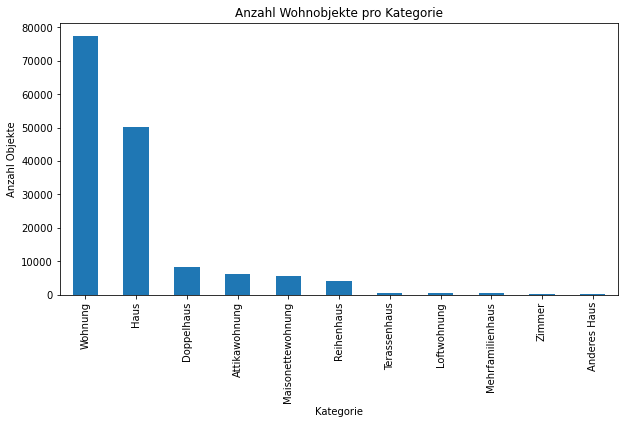

In [5]:
csv_data['GroupNameDe'].value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie")
plt.show()

 Man kann im Plot sehr gut erkennen, dass es sich hier im eine ungleichmäsige Verteilung der Kategorien handelt. Da man einige Kategorien gar nicht erkennen kann, schauen wir noch die Zahlen an:

In [6]:
 csv_data['GroupNameDe'].value_counts()

Wohnung              77499
Haus                 50265
Doppelhaus            8397
Attikawohnung         6215
Maisonettewohnung     5517
Reihenhaus            4168
Terassenhaus           533
Loftwohnung            474
Mehrfamilienhaus       444
Zimmer                  89
Anderes Haus            26
Name: GroupNameDe, dtype: int64

Wir sehen also klar, dass die Daten extrem unbalanced sind. Dazu gibt es verschiedene Techniken. In der Challenge haben wir Oversampling benutzt.

### Oversampling
Oversampling bedeutet, dem Datensatz werden neue Objekte hinzugefügt um eine "Anzahl"-Balance zwischen allen Klassen herzustellen. Hierfür kann man bestehende Objekte zufällig auswählen und mehrmals hinzufügen bzw. kopieren oder komplett neue Objekte – basierend auf den bereits existierenden – erstellen. Dies funktioniert beispielsweise mit der SMOTE Methode. Hiermit werden wir uns auch beschäftigen.

In [11]:
ros = RandomOverSampler(random_state = 69)
X_random_, y_random_ = ros.fit_resample(prepro.X_train, prepro.y_train)
X_random = X_random_.sample(len(prepro.X_train), random_state = 69)
y_random = y_random_.iloc[X_random.index]

### Model trainieren
Wie oben gesagt, wird das NN verglichen mit einem Lightgbm-Mode, welches zu den "Boosted Tree"-Modellen gehört. Die besten Parameter haben wir schon gefunden gehabt mit Hilfe von Bayesian Optimization.

In [22]:
lgbc_best = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = 0.07517, max_depth = 340, n_estimators = 344,
        num_leaves = 90, reg_alpha = 1.136, reg_lambda = 4.348
)
lgbc_best.fit(X_random, y_random)

LGBMClassifier(learning_rate=0.07517, max_depth=340, n_estimators=344,
               num_leaves=90, reg_alpha=1.136, reg_lambda=4.348, seed=42)

In [23]:
lgbc_y_pred_best = lgbc_best.predict(prepro.X_test)

In [24]:
 print(sklearn.metrics.classification_report(prepro.y_test, lgbc_y_pred_best))

                   precision    recall  f1-score   support

     Anderes Haus       0.00      0.00      0.00         5
    Attikawohnung       0.32      0.67      0.43      1243
       Doppelhaus       0.40      0.59      0.48      1679
             Haus       0.92      0.80      0.85     10053
      Loftwohnung       0.45      0.55      0.50        95
Maisonettewohnung       0.29      0.58      0.39      1103
 Mehrfamilienhaus       0.30      0.54      0.39        89
       Reihenhaus       0.39      0.60      0.47       834
     Terassenhaus       0.48      0.63      0.54       107
          Wohnung       0.95      0.80      0.87     15500
           Zimmer       0.12      0.11      0.12        18

         accuracy                           0.76     30726
        macro avg       0.42      0.53      0.46     30726
     weighted avg       0.84      0.76      0.79     30726



In [25]:
prepro.X_test.shape

(30726, 136)

### Confusion Matrix LightGBM

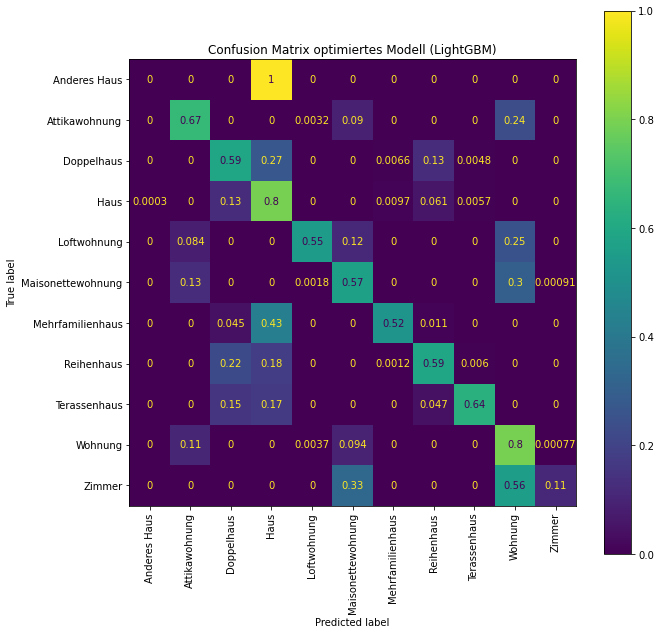

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(lgbc_best, prepro.X_test, prepro.y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix optimiertes Modell (LightGBM)')
plt.show()

## Wichtigkeit der Features

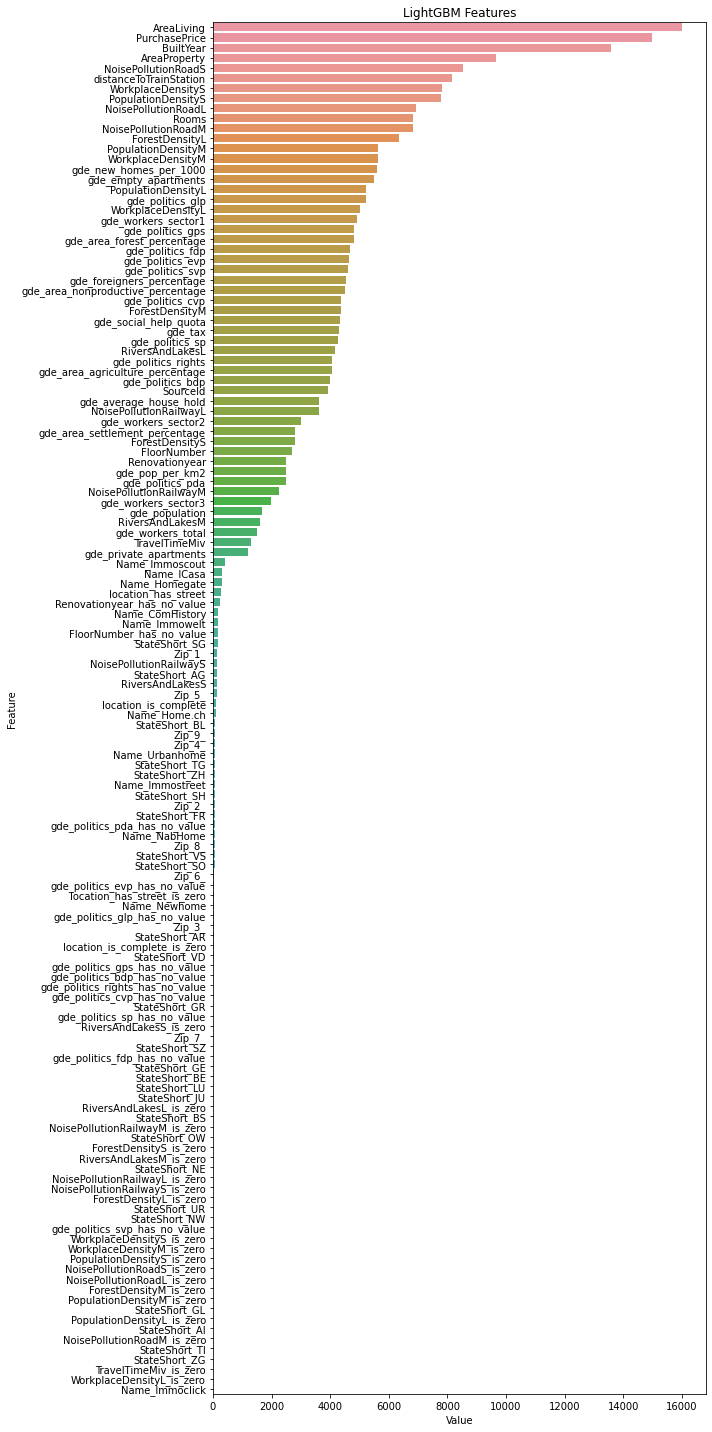

<Figure size 432x288 with 0 Axes>

In [30]:
feature_imp = pd.DataFrame(sorted(zip(lgbc_best.feature_importances_,prepro.X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Wir sehen also, dass die meisten Features gar keinen Einfluss haben auf die Klassifizierung. Wir stehlen diese Informationen für unser NN um dieses nicht mit Features zu überladen, welche keine Information beinhalten. Für das NN behalten wir also nur diese, welche mehr Einfluss haben als deren Wichtigkeit geteilt durch 2. Damit haben wir noch 53 Features.

In [31]:
features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]

<ipython-input-31-8b8535232176>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]


In [32]:
features_to_drop

,Value,Feature
0,0,Name_Immoclick
1,0,NoisePollutionRoadM_is_zero
2,0,PopulationDensityL_is_zero
3,0,PopulationDensityM_is_zero
4,0,StateShort_AI
...,...,...
78,253,Renovationyear_has_no_value
79,259,location_has_street
80,299,Name_Homegate
81,322,Name_ICasa


In [33]:
# Save Features to drop:
features_to_drop.to_csv('features_to_drop.csv', index=False)

In [34]:
# Load Features to drop (to avoid having to rerun the whole notebook each time)
features_to_drop = pd.read_csv('features_to_drop.csv')

## Neural Network-Model
LightGBM macht automatisch aus String Zahlen, welche vom Model verstanden werden können. Pytorch macht das nicht; Wir müssen also die Wohnobjekte Onehot-Encoden. Als erstes definieren wir Funktionen, welche ein Model nach folgenden Angaben erstellt:
- Welcher Optimizer verwendet wird (ADAM oder SGD)
- Wieviele Hidden Layers es hat
- Wieviele Neuronen ein Hidden Layer hat
    - Einen guten Anfangswert haben wir mit Hilfe von einem [Artikel auf Stackexchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) gefunden
- Ob regularisiert wird oder nicht mit Dropout
- Falls regularisiert wird, wieviele Neuronen pro Layer sollen jeweils zufälligerweise null gesetzt werden.

## Use of the Library Cuda for the NN 
Currently, this Notebook only runs when Cuda is corrently installed.

In [35]:
if not torch.cuda.is_available():
    NotImplementedError
if torch.cuda.is_available():
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

Cuda Device Available
Name of the Cuda Device:  GeForce GTX 1650
GPU Computational Capablity:  (7, 5)


### Daten vorbereiten mit der Klasse PreProcessor
Das Preprocessing wird genau gleich durchgeführt wie beim LightGBM. Zusätzlich entfernen wir aber noch die Attribute, welche laut dem LightGBM-Model kaum oder keinen Einfluss haben auf das Model.

### Evaluieren der Modelle
Zur Evaluierung der Modelle benutzen wir Sklearn und nehmen wie beim LightGBM die macro F1-Score.

### Tunen der Hyperparameter
Zum tunen der Hyperparameter benutzen wir das Packet [BayesianOptimization](https://github.com/fmfn/BayesianOptimization), welches Bayesianische globale Optimierung durchführt mit Gauß-Prozessen.


In [36]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()


## Drop der Attribute, welche laut dem LightGBM-Model kaum Einfluss haben:
prepro.X_train = prepro.X_train.drop(columns=features_to_drop['Feature'].to_list())
prepro.X_test = prepro.X_test.drop(columns=features_to_drop['Feature'].to_list())

#### Namen label-encoden.
Damit die Gewichte auch der richtigen Klasse entsprechen, definieren wir ein Dictionary, damit das Label-Encoden sicherlich für Train, Test und die Gewichte stimmt.

In [37]:
le_dict = {name:nr for nr, name in enumerate(prepro.y_train.unique())}

In [38]:
y_train_le = prepro.y_train.replace(le_dict)
y_test_le = prepro.y_test.replace(le_dict)

# Create Weights to count for class inbalance:
value_counts_le = prepro.y_train.value_counts().reindex(le_dict)
weights = torch.tensor(1 / (value_counts_le /value_counts_le.sum()), dtype=torch.float32).cuda() 

#### Daten und Modell auf die GPU laden

In [39]:
# Falls wir etwas auf der GPU laufen möchten, müssen wir Pytorch explizit sagen, das es das Model und die benötigten Daten auf die GPU schreiben soll:
if torch.cuda.is_available():
    print("Cuda detected and used by Pytorch!")

else: 
    print("Cuda was not detected and no GPU is used. Training takes a long time, even with a RTX 3060TI, so try to make Pytorch use CUDA.")
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Cuda detected and used by Pytorch!


#### Dataloader definieren

In [40]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
        'Initialization'
        self.X = X
        self.Y = Y

  def __len__(self):
        'Denotes the total number of samples'
        return np.shape(self.X)[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [41]:
training_set = Dataset(prepro.X_train.values.astype(np.float32), y_train_le.values)

In [42]:
# Move Test data to device:
y_le_test_t = torch.tensor(y_test_le.values, dtype=torch.long).to(device)
X_test_t = torch.tensor(prepro.X_test.values, dtype=torch.float32).to(device)

#### Funktionen definieren, um das beste NN zu finden
Wir können mit der Funktion `calc_nr_neuros` einen guten Startwert finden. Es ist natürlich sehr Pi * Daumen gerechnet. Als Parameter haben wir da alpha, 

In [43]:
def calc_nr_neuros(X, output_neurons, alpha=2):
    """
    This function calculates with pi * thumb how many neuros there should be in a hidden layer.
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    :dataframe X: train-dataset which will be given to the NN.
    :numeric alpha: parameter to change the number of neurons in the hidden layer
    :return: starting value for the number of neurons
    """
    sample_size, input_dim = X.shape
    return int(sample_size / (alpha * (input_dim + output_neurons)))

In [44]:
# Parameter for the model
input_dim = prepro.X_train.shape[1]
output_dim = len(y_test_le.unique())
min_neur = calc_nr_neuros(prepro.X_train, output_dim, 7)
max_neur = calc_nr_neuros(prepro.X_train, output_dim, 2)
# Epoch Parameters:
MAX_EPOCHS = 100
MAX_EPOCH_NO_IMPROVE = 15

#EARLY STOPPING PARAMETERS:
MEASURE_FOR_EARLY_STOPPING = 'F1 Score'
SCORING_FUNCTION = sklearn.metrics.f1_score

# Function to use before prediction:
m = nn.Softmax(dim=1)

print("Ein guter Anfangsbereich für die Suche der optimalen Anzahl der Neuronen geht von {} bis {}.".format(min_neur, max_neur))

# Parameter for the Data loader:
params_data_loader = {
    'shuffle': True,
    'num_workers': 0 # I was not able to run num_workers with a higher setting than 0. Found this issue: https://github.com/xingyizhou/CenterNet/issues/566 Apparently it's a problem with jupyter-notebooks.
    }




Ein guter Anfangsbereich für die Suche der optimalen Anzahl der Neuronen geht von 274 bis 960.


### Hilfsfunktionen um das neuronale Netz zu bilden und es zu evaluieren
#### Initalisierung der Gewichte
Die Gewichte werden zufälligerweise mit verschiedenen Methoden initalisiert. Falls wir alle Gewichte mit 0 initalisieren würden, wäre die Ausgabe der Aktivierungsfunktion in den Hidden Layers 0. Somit wäre der Gradient 0 und das NN könnte nicht lernen. Falls wir alle Gewichte mit dem gleichen Wert (z.B 1 ) initalisieren, ist der Output aller Aktivierungsfunktionen in den Hidden Layers identisch und der Gradient für alle Neuronen wieder gleich. Somit werden die Gewichte zufällig initalisiert. Hierzu wurden ebenfalls verschiedene Methoden entwickelt und getestet. Die von Pytorch kann man [hier](https://pytorch.org/docs/stable/nn.init.html) nachlesen. Nachfolgend benutzen wir die Methode `kaiming uniform`, welche uniform Gewichte bestimmt.


In [84]:
def one_hot_ce_loss(outputs, target, weights=None):    
    """
    CrossEntropyLoss accepts only label-encoded predictions. 
    See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html"""
    if weights is not None:
        criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean')
    else: 
        criterion = nn.CrossEntropyLoss()
    return criterion(outputs, target)

def create_model(nr_layers, hdim, dropout, batchnorm, reg):
    """
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float drouput: How many % of Neurons should randomy "dropped out".
    :bool batchnorm: If a layer should include batchnorm.
    :bool reg: If regularisation should be applied and which kind.
    :return: Pytorch Model.
    """
    class Model(nn.Module):
        def __init__(self, input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg):
            super().__init__()

            self.layers = nn.ModuleList()
            first_layer = True

            # Input layer:
            self.layers.append(nn.Linear(input_dim, hdim))
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(hdim))
            if reg == 'Dropout':
                self.layers.append(nn.Dropout(dropout))


            # Hidden Layers:
            current_dim = hdim
            for i in range(nr_layers):
                self.layers.append(nn.Linear(hdim, current_dim))
                if batchnorm:
                    self.layers.append(nn.BatchNorm1d(current_dim))
                if reg == 'Dropout':
                    self.layers.append(nn.Dropout(dropout))

                # Reduce number of neurons based on depth of current layer:
                hdim = current_dim
                current_dim = int(current_dim / np.e**((i+1)/nr_layers)) # Formula has a nice decay. It's chosen arbitrarily.
            
            # Output Layer:
            self.layers.append(nn.Linear(hdim, output_dim))

            # Inizialize weights:
            self.iniziate_weights()

        def forward(self,x):
            for layer in self.layers[:-1]:
                if isinstance(layer, torch.nn.modules.linear.Linear):
                    x = F.relu(layer(x))
                else:
                    x = layer(x)

            x = self.layers[-1](x)

            return x

        def iniziate_weights(self):
            for m in self.layers:
                if isinstance(m, torch.nn.modules.linear.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0.01)

                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    return Model(input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [91]:
def create_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg):
    """
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :return: Pytorch Model and optimizer-object.
    """
    assert optimizer in ['SGD', 'Adam'], "Please Enter SGD or Adam as Optimizer"
    assert reg in ['Dropout', 'L1', 'L2', None], "Please Enter L1, L2, Dropout or None as reg"
    assert all(isinstance(i, int) for i in [nr_layers, hdim]), "Please check types of Parameter"
    assert all(isinstance(i, float) for i in [dropout, lr_rate]), "Please check types of Parameter"

    model = create_model(nr_layers, hdim, dropout, batchnorm, reg).to(device)

    if optimizer == 'SGD':
        optimizer_object = torch.optim.SGD(params = model.parameters(), lr=lr_rate)
    elif optimizer == 'Adam':
        optimizer_object = torch.optim.Adam(params = model.parameters(), lr=lr_rate)

    return model, optimizer_object

def fit_NN(model, optimizer, reg, reg_factor, batch_size, EPOCHS=MAX_EPOCHS, MAX_EPOCH_NO_IMPROVE=MAX_EPOCH_NO_IMPROVE):
    """
    :pytorch model model: Model to train
    :pytorch optimizer optimizer: Optimizer to use for the training (Adam or SGD)
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int BATCH_SIZE: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :return: aggregated_losses and test_losses
    """

    # Create Range and lists for saving the losses:
    epoch_loop = range(EPOCHS)
    train_losses = []
    test_losses = []
    test_scores = []

    # Set parameters for early stopping to dummy-value:
    lowest_loss = np.inf
    best_score = 0
    epoch_no_improve = 0


    # Data Generators:
    training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, **params_data_loader)

    for i in epoch_loop:
        current_loss = torch.tensor(0.0, dtype=torch.float32).to(device)
        for x, y in training_generator:
            # Move x, y to device:
            x, y = x.to(device), y.to(device)
            # Predict, calculate loss and update weights
            y_pred = model(x)
            single_loss = one_hot_ce_loss(y_pred, y, weights)

            # Set gradients to zero:
            optimizer.zero_grad()

            # Apply L1/2 Regularisation:
            # Technically, L2 Regularisation can also be passed to the optimizer with the weight_decay parameter. However, this is not aviabile for the L1 regularisation directly in the optimizer.
            # Thus, we would need to do L1 regularisation here and L2 in the optimizer, which is annoying.
            l_regularization = torch.tensor(0.0, dtype=torch.float64).to(device)
            model_weights_sum = torch.tensor(0.0, dtype=torch.float64).to(device)

            
            for name, param in model.named_parameters():
                if 'weight' in name:
                    model_weights_sum = param.abs().sum() / training_set.__len__()
                    if reg == 'L1':
                        l_regularization += model_weights_sum * reg_factor
                    elif reg == 'L2':
                        l_regularization += model_weights_sum ** 2  * reg_factor 
                        
            
            # Update Loss with L Regularisation:
            single_loss += l_regularization 

            # Backward Prop:
            single_loss.backward()

            # Update Weights:
            optimizer.step()

            current_loss += single_loss.float()
        
        current_loss = current_loss / (training_set.__len__() / batch_size)

        # Tell Pytorch that it's in eval-mode.
        model.eval()
        with torch.no_grad():
            current_test_loss = one_hot_ce_loss(model(X_test_t), y_le_test_t, weights) + l_regularization # Test loss does currently not add regularisation to the train-loss. Should it? If yes, how?
            current_score = SCORING_FUNCTION(y_le_test_t.cpu(), model(X_test_t).cpu().argmax(axis = 1), average='macro')


        # Easy early stopping implementation:
        if torch.isnan(current_loss).any() or (epoch_no_improve > MAX_EPOCH_NO_IMPROVE):
            break

        if MEASURE_FOR_EARLY_STOPPING == 'F1 Score':
            if i > 1 and best_score < current_score:
                best_score = current_score
                epoch_no_improve = 0

        else:
            if i > 1 and lowest_loss > test_losses[-1]:
                lowest_loss = test_losses[-1]
                epoch_no_improve = 0
        
        epoch_no_improve += 1

        with torch.no_grad():
            train_losses.append(current_loss)
            test_losses.append(current_test_loss)
            test_scores.append(current_score)

            # Wandb logging:
            wandb.log({"test loss":current_test_loss})
            wandb.log({"train loss":current_loss})
            wandb.log({"F1 Score":current_score})
            wandb.log({"Sum of Weights / # training samples":model_weights_sum})


        # Tell pytorch to switch back to training-mode:    
        model.train()
    
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

    return train_losses, test_losses, test_scores

def bayesian_opt_result_to_dict(bay_opt_res, scoring='F1 Score'):
    """
    bayesian optimization result bay_opt_res: Finished object for bayesian optimization.
    returns: DataFrame with results
    """
    results = []
    for result in bay_opt_res:
        dict_ = {scoring: result['target']}
        dict_.update(result['params'])
        results.append(dict_)

    return pd.DataFrame(results).sort_values(by=scoring, ascending=False)


def create_fit_evaluate_NN(return_all=False):
    """This function puts all the previous functions together; It creates a model, trains it and evaluates it.
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int batch_size: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :return: Weighted F1 Score and if return_all is set to True, the fitted model, aggregated losses and test losses
    """

    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'optimizer': 'SGD',
        'nr_layers': 4,
        'hdim': 420,
        'dropout': 0.0,
        'lr_rate': 0.01,
        'reg': None,
        'batchnorm': False,
        'reg_factor': 0.0,
        'batch_size': 64
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    model, optimizer_object = create_NN(config.optimizer, config.nr_layers, config.hdim, config.dropout, config.lr_rate, config.batchnorm, config.reg)
    train_losses, test_losses, test_scores = fit_NN(model, optimizer_object, config.reg, config.reg_factor, config.batch_size)

        
    with torch.no_grad():
        f1_score = SCORING_FUNCTION(y_le_test_t.cpu(), model(X_test_t).cpu().argmax(axis = 1), average='macro')

    if return_all:
        return f1_score, model, train_losses, test_losses, test_scores


### Funktion zur Evaluerung von NNs
Mit der Funktion `create_fit_evaluate_NN` haben wir eine Funktion erstellt, welche eine F1-Score zurückgibt und folgende Parameter als Argumente hat:
- optimizer: SGD or Adam
- nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
- hdim: Hidden Dimensions (number of neurons)
- dropout: How many % of Neurons should be randomly "dropped out".
- lr_rate: Learning rate.
- batchnorm: If a layer should include batchnorm.
- reg: If regularisation should be applied. 
- BATCH_SIZE: how big one batch should be
- EPOCHS: How many epochs should be used for training.
- MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.

### Bestmögliches Modell ohne Regularisierung, ohne Batchnorm und SGD als Optimizer
Wir finden nun das bestmögliche NN ohne Regularisierung, ohne Batchnorm und SGD als Optimizer mit Bayesian Optimization. Zur Optimieren benutzen wir [WandB](https://wandb.ai/), welches ein tolles und übersichtliches Tool zur Verfügung stellen. Mit "Sweepen" ist "Parameter testen und schauen, welche am besten sind". [Hier](https://docs.wandb.ai/guides/sweeps) gibt es eine Anleitung dazu.

Als Optimierungsmethode benutzen wir "Bayes", welches nach dem "Bayesianisches Prinzip" schlau Parameter durchtested. [Hier](https://wandb.ai/site/articles/bayesian-hyperparameter-optimization-a-primer) gibt es eine gute Übersicht.

In [77]:
# Parameter for Sweep:
MAX_RUNS_FOR_SWEEP=15

In [86]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 4,
                'max': 9
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
             'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            }
        }

In [87]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: wzh1na78
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/wzh1na78
wandb: Agent Starting Run: yq3eokac with config:
wandb: 	batch_size: 477
wandb: 	hdim: 885
wandb: 	learning_rate: 0.06579866555649966
wandb: 	nr_layers: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history


test loss,2.38938
_runtime,7
_timestamp,1620744204
_step,2
train loss,2.30873
F1 Score,0.01841


test loss,▁
_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█
train loss,▁
F1 Score,▁


Run yq3eokac errored: UnboundLocalError("local variable 'model_weights_sum' referenced before assignment")
wandb: ERROR Run yq3eokac errored: UnboundLocalError("local variable 'model_weights_sum' referenced before assignment")
wandb: Agent Starting Run: 798ao0zo with config:
wandb: 	batch_size: 450
wandb: 	hdim: 662
wandb: 	learning_rate: 0.07549633538908224
wandb: 	nr_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history


test loss,1.88092
_runtime,7
_timestamp,1620744215
_step,2
train loss,2.02976
F1 Score,0.11046


test loss,▁
_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█
train loss,▁
F1 Score,▁


Run 798ao0zo errored: UnboundLocalError("local variable 'model_weights_sum' referenced before assignment")
wandb: ERROR Run 798ao0zo errored: UnboundLocalError("local variable 'model_weights_sum' referenced before assignment")
wandb: Agent Starting Run: y0dsjnwu with config:
wandb: 	batch_size: 92
wandb: 	hdim: 279
wandb: 	learning_rate: 0.02140347510910753
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history


test loss,1.76324
_runtime,9
_timestamp,1620744229
_step,2
train loss,1.73144
F1 Score,0.23817


test loss,▁
_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█
train loss,▁
F1 Score,▁


Run y0dsjnwu errored: UnboundLocalError("local variable 'model_weights_sum' referenced before assignment")
wandb: ERROR Run y0dsjnwu errored: UnboundLocalError("local variable 'model_weights_sum' referenced before assignment")
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


### Ergebniss
Das Ergebiss kann hier nachgeschaut werden:

https://wandb.ai/vincenzo293/DEL-mini-challenge-1/reports/Bestm-gliches-Modell-ohne-Regularisierung-ohne-Batchnorm-und-SGD-als-Optimizer--Vmlldzo2NzcyNjQ/

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und SGD als Optimizer
#### Warum Regularisieren?
Der Sinn der regularisierung ist, Overfitting zu verhindern. Dropout tut dies, in dem es einen gewissen %-Satz pro Layer auf 0 setzt. Bei der L1/L2 Regularisierung wird dagegen die absolute oder quadrierte Norm der Gewichte zum Loss hinzuaddiert. Somit verändert sich der Gradient, welcher die Gewichte anpasst. Dies funktioniert, da im Allgemeinen grosse Gewichte auf Overfitting hindeuten und grosse Gewichte werden durch beide L-Regularisierungen bestraft. 

Der Unterschied zwischen L1 und L2 ist, dass bei L1, da man den absoluten Wert nimmt zum summieren, mehr 0 gesetzt. Bei der L2, da die Gewichte quadiert werden und die Quadrierung kleine Werte noch kleiner macht, werden die Gewichte einfach verkleinert, aber werden nicht 0 gesetzt.

In [92]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 4,
                'max': 9
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
            'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            'reg': {
                 'distribution': 'categorical',
                 'values': ['L1', 'L2', 'Dropout']
                 },
            'reg_factor': {
                'distribution': 'uniform',
                    'min': 0.0001,
                    'max': 0.5
                },
            'dropout': {
                'distribution': 'uniform',
                    'min': 0.01,
                    'max': 0.3
                }   
        }
}

In [93]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: 4wih5x3r
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/4wih5x3r
wandb: Agent Starting Run: 53qctrh0 with config:
wandb: 	batch_size: 105
wandb: 	dropout: 0.28419124298589193
wandb: 	hdim: 834
wandb: 	learning_rate: 0.017132178176450297
wandb: 	nr_layers: 7
wandb: 	reg: L1
wandb: 	reg_factor: 0.12027896934081964
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  70 loss: 0.5532297492
Run pip install nbformat to save notebook history


test loss,4.8797
_runtime,761
_timestamp,1620745173
_step,279
train loss,0.31443
F1 Score,0.35245
Sum of Weights,0.00103


test loss,▂▂▁▁▁▁▂▁▁▁▂▂▂▃▃▃▃▄▃▄▄▄▄▄▆▄▆▆▇█▇█▇▇▇▆▅▅▇█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁
F1 Score,▁▄▄▅▅▄▄▅▅▅▅▅▅▆▅▆▅▇▆▆▆▇▇▇▇▇▇▇▇█████▇▇▆▆██
Sum of Weights,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████


wandb: Agent Starting Run: eheadmlr with config:
wandb: 	batch_size: 298
wandb: 	dropout: 0.0915760691547992
wandb: 	hdim: 877
wandb: 	learning_rate: 0.00497731560976274
wandb: 	nr_layers: 9
wandb: 	reg: L2
wandb: 	reg_factor: 0.029817710463249852
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  63 loss: 0.9332612753
Run pip install nbformat to save notebook history


test loss,4.12032
_runtime,395
_timestamp,1620745592
_step,251
train loss,0.35021
F1 Score,0.3377
Sum of Weights,0.00052


test loss,▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▃▄▄▅▅▆▆▆▆▇▆█▇▇▇▆▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▇▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▄▄▅▅▄▅▅▆▅▆▆▅▆▆▆▆▅▆▆▇▆▇▇▇▇▇▇▇██▇▆█▆▇█▇▇
Sum of Weights,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████


wandb: Agent Starting Run: 8ownijo1 with config:
wandb: 	batch_size: 67
wandb: 	dropout: 0.19114962283140755
wandb: 	hdim: 856
wandb: 	learning_rate: 0.08876204721904642
wandb: 	nr_layers: 5
wandb: 	reg: L2
wandb: 	reg_factor: 0.18404271333392094
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  22 loss: 0.8317449689
Run pip install nbformat to save notebook history


test loss,2.60172
_runtime,332
_timestamp,1620745938
_step,87
train loss,0.63478
F1 Score,0.30412
Sum of Weights,0.00162


test loss,▃▂▂▁▂▂▂▂▂▂▃▂▅▃▅▅▇▇▇▆▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
F1 Score,▃▁▄▇▅▆██▅▆▆▅▇▅▆▇▆▇█▇▆▇
Sum of Weights,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: gh2zetdw with config:
wandb: 	batch_size: 367
wandb: 	dropout: 0.25871866039998426
wandb: 	hdim: 531
wandb: 	learning_rate: 0.02729064988504676
wandb: 	nr_layers: 6
wandb: 	reg: L1
wandb: 	reg_factor: 0.07886278898945157
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  70 loss: 0.2288148254
Run pip install nbformat to save notebook history


test loss,1.98549
_runtime,296
_timestamp,1620746256
_step,279
train loss,0.73229
F1 Score,0.28604
Sum of Weights,0.00096


test loss,▃▂▂▂▂▁▁▃▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇██▇▆▇██▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
F1 Score,▃▁▂▃▄▅▃▄▅▅▅▅▅▅▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██▇▆
Sum of Weights,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████


wandb: Agent Starting Run: daui373y with config:
wandb: 	batch_size: 214
wandb: 	dropout: 0.06757561106972398
wandb: 	hdim: 695
wandb: 	learning_rate: 0.019700375666652302
wandb: 	nr_layers: 6
wandb: 	reg: L1
wandb: 	reg_factor: 0.4263205502395911
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run pip install nbformat to save notebook history


### Ergebniss
Das Ergebiss kann hier nachgeschaut werden:

https://wandb.ai/vincenzo293/DEL-mini-challenge-1/reports/Bestm-gliches-Modell-mit-Regularisierung-ohne-Batchnorm-und-SGD-als-Optimizer--Vmlldzo2Nzc1NzA

### Bestmögliches Modell ohne Regularisierung, mit Batchnorm und SGD als Optimizer

In [53]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 4,
                'max': 9
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
            'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            'batchnorm': {
                 'distribution': 'categorical',
                 'values': [True]
                 },
        }
}

In [54]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: n8mradby
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/n8mradby
wandb: Agent Starting Run: dkbg8vki with config:
wandb: 	batch_size: 85
wandb: 	batchnorm: True
wandb: 	hdim: 925
wandb: 	learning_rate: 0.06700047519180846
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  80 loss: 0.0643319860
Run pip install nbformat to save notebook history


test loss,3.60055
_runtime,827
_timestamp,1620660788
_step,239
train loss,0.2714
F1 Score,0.36508


test loss,▁▁▁▁▂▂▂▂▃▄▃▄▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▃▃▃▃▄▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▆▆▇▇▇█▇▇██▇██


wandb: Agent Starting Run: pxc62iuk with config:
wandb: 	batch_size: 233
wandb: 	batchnorm: True
wandb: 	hdim: 596
wandb: 	learning_rate: 0.00812089642699398
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.1550175548
Run pip install nbformat to save notebook history


test loss,3.48419
_runtime,404
_timestamp,1620661210
_step,299
train loss,0.21089
F1 Score,0.36551


test loss,▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇███▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇█▇█▇█████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bhr0plos with config:
wandb: 	batch_size: 254
wandb: 	batchnorm: True
wandb: 	hdim: 917
wandb: 	learning_rate: 0.04534993874449179
wandb: 	nr_layers: 9
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  70 loss: 0.2839864194
Run pip install nbformat to save notebook history


test loss,2.21392
_runtime,398
_timestamp,1620661623
_step,209
train loss,0.34982
F1 Score,0.33714


test loss,▃▂▂▁▁▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇███▇███▅▄▄▄
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁
F1 Score,▁▂▄▅▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇█▇██▇███████▇▅▆▇▇


wandb: Agent Starting Run: cl7bgmvs with config:
wandb: 	batch_size: 301
wandb: 	batchnorm: True
wandb: 	hdim: 600
wandb: 	learning_rate: 0.0030950879905309123
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.4972683787
Run pip install nbformat to save notebook history


test loss,3.58918
_runtime,347
_timestamp,1620661981
_step,299
train loss,0.20355
F1 Score,0.36363


test loss,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█▆▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇████▅▇▇██████


wandb: Agent Starting Run: iwhzqnxn with config:
wandb: 	batch_size: 180
wandb: 	batchnorm: True
wandb: 	hdim: 702
wandb: 	learning_rate: 0.04115365861110578
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.3673513532
Run pip install nbformat to save notebook history


test loss,3.98587
_runtime,504
_timestamp,1620662490
_step,299
train loss,0.19041
F1 Score,0.37937


test loss,▁▁▁▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇██▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇██


wandb: Agent Starting Run: a2bpzmi4 with config:
wandb: 	batch_size: 162
wandb: 	batchnorm: True
wandb: 	hdim: 711
wandb: 	learning_rate: 0.059693103348053556
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  83 loss: 0.3379836977
Run pip install nbformat to save notebook history


test loss,3.64839
_runtime,462
_timestamp,1620662958
_step,248
train loss,0.22915
F1 Score,0.35858


test loss,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇██▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▃▄▄▄▅▅▅▅▆▆▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██▇▇▇██▇


wandb: Agent Starting Run: ijdn5cjq with config:
wandb: 	batch_size: 238
wandb: 	batchnorm: True
wandb: 	hdim: 595
wandb: 	learning_rate: 0.011215276537693749
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  70 loss: 0.2849233747
Run pip install nbformat to save notebook history


test loss,3.42263
_runtime,299
_timestamp,1620663268
_step,209
train loss,0.26084
F1 Score,0.35464


test loss,▁▁▁▂▂▃▃▃▃▃▄▄▄▅▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██████


wandb: Agent Starting Run: ibnnnznr with config:
wandb: 	batch_size: 457
wandb: 	batchnorm: True
wandb: 	hdim: 476
wandb: 	learning_rate: 0.09852947294761218
wandb: 	nr_layers: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  78 loss: 0.5245512724
Run pip install nbformat to save notebook history


test loss,2.43013
_runtime,280
_timestamp,1620663557
_step,233
train loss,0.68063
F1 Score,0.27296


test loss,▃▂▁▁▁▂▂▂▂▃▂▃▃▃▄▄▄▄▄▅▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇███▇▅
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
F1 Score,▁▂▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█████▇▇▆


wandb: Agent Starting Run: dchz54z9 with config:
wandb: 	batch_size: 246
wandb: 	batchnorm: True
wandb: 	hdim: 690
wandb: 	learning_rate: 0.0460960814978089
wandb: 	nr_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.1890899241
Run pip install nbformat to save notebook history


test loss,3.72367
_runtime,454
_timestamp,1620664020
_step,299
train loss,0.18532
F1 Score,0.36799


test loss,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▅▅▅▅▆▆▆▅▆▆▇▇▇▇▇▇▇█▇▇▇▇█████▇▇▆██████


wandb: Agent Starting Run: 5j33mj0x with config:
wandb: 	batch_size: 151
wandb: 	batchnorm: True
wandb: 	hdim: 724
wandb: 	learning_rate: 0.024488527929631063
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.4734165668
Run pip install nbformat to save notebook history


test loss,3.68388
_runtime,691
_timestamp,1620664717
_step,299
train loss,0.22107
F1 Score,0.35236


test loss,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▃▄▄▄▄▅▅▆▅▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇▅▆▇▇███▇█████▇


wandb: Agent Starting Run: ywxeqsze with config:
wandb: 	batch_size: 259
wandb: 	batchnorm: True
wandb: 	hdim: 716
wandb: 	learning_rate: 0.03416592784501076
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  83 loss: 0.3946496844
Run pip install nbformat to save notebook history


test loss,3.32758
_runtime,319
_timestamp,1620665043
_step,248
train loss,0.24925
F1 Score,0.33435


test loss,▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇███▆
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▆▆▇▆▇▇▇█▇█▇█▇▇██████▇█▆


wandb: Agent Starting Run: ztk1nt2z with config:
wandb: 	batch_size: 140
wandb: 	batchnorm: True
wandb: 	hdim: 769
wandb: 	learning_rate: 0.0526600259950056
wandb: 	nr_layers: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.2740404308
Run pip install nbformat to save notebook history


test loss,3.66387
_runtime,575
_timestamp,1620665628
_step,299
train loss,0.21637
F1 Score,0.36945


test loss,▁▁▂▂▂▂▃▃▄▃▄▄▅▅▄▅▅▅▅▅▆▆▅▆▆▇▆▆▆▇▇▇▇████▇█▇
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▁▃▄▄▄▅▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇█▇▇█▇▇▇▇███▇███


wandb: Agent Starting Run: 92qaeamo with config:
wandb: 	batch_size: 194
wandb: 	batchnorm: True
wandb: 	hdim: 611
wandb: 	learning_rate: 0.0005763018059599572
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.3367980123
Run pip install nbformat to save notebook history


test loss,3.51586
_runtime,350
_timestamp,1620665985
_step,299
train loss,0.21268
F1 Score,0.35092


test loss,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▄▅▅▅▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▁▂▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▆▅▆▇▆▆▇▇▇▇▇▇▇▇█▇██████▇


wandb: Agent Starting Run: y136a7j5 with config:
wandb: 	batch_size: 50
wandb: 	batchnorm: True
wandb: 	hdim: 477
wandb: 	learning_rate: 0.08804607475863502
wandb: 	nr_layers: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.9279655814
Run pip install nbformat to save notebook history


test loss,3.27572
_runtime,1079
_timestamp,1620667069
_step,299
train loss,0.40105
F1 Score,0.33898


test loss,▂▁▁▂▂▂▂▃▃▄▃▃▄▄▅▅▄▅▅▅▆▆▅▅▅▆▆▆▇▇▇▇▇██▇▇██▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▁▃▃▃▂▄▃▄▄▄▄▄▅▅▅▅▆▅▅▆▆▅▆▅▆▇▇▇▇▇▇▇█▇▇▇▇█▇


wandb: Agent Starting Run: 1le55sld with config:
wandb: 	batch_size: 252
wandb: 	batchnorm: True
wandb: 	hdim: 827
wandb: 	learning_rate: 0.06023038726221833
wandb: 	nr_layers: 6
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  99 loss: 0.2599436641
Run pip install nbformat to save notebook history


test loss,3.93994
_runtime,386
_timestamp,1620667471
_step,299
train loss,0.15956
F1 Score,0.37867


test loss,▂▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▄▄▅▆▇▇▇▇▇█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁
F1 Score,▁▃▄▄▅▄▅▅▆▆▆▅▆▇▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▄▆▇▇▇▇██▇█


### Resultate
Die Resulate findet man hier: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/reports/Bestm-gliches-Modell-ohne-Regularisierung-mit-Batchnorm-und-SGD-als-Optimizer--Vmlldzo2Nzc2Njk

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und Adam als Optimizer

In [62]:
# Parameter to Sweep:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'F1 Score',
         'goal': 'maximize'   
         },
         'parameters': {
             'batch_size': {
                 'distribution': 'int_uniform',
                 'min': 32,
                 'max': 512
                 },
             'nr_layers': {
                'distribution': 'int_uniform',
                'min': 4,
                'max': 9
                },
            'hdim': {
                'distribution': 'int_uniform',
                'min': min_neur,
                'max': max_neur
                },
            'learning_rate': {
                 'distribution': 'uniform',
                 'min': 0.0001,
                 'max': 0.1
                 },
            'reg': {
                 'distribution': 'categorical',
                 'values': ['L1', 'L2', 'Dropout']
                 },
            'reg_factor': {
                'distribution': 'uniform',
                    'min': 0.001,
                    'max': 1.0
                },
            'dropout': {
                'distribution': 'uniform',
                    'min': 0.01,
                    'max': 0.3
                },
            'optimizer': {
                 'distribution': 'categorical',
                 'values': ['Adam']
                 },
        }
}

In [63]:
# Define how this Sweep should be logged:
sweep_id = wandb.sweep(sweep_config, project='DEL-mini-challenge-1')

# Start the sweep:
wandb.agent(sweep_id, function=create_fit_evaluate_NN, count=MAX_RUNS_FOR_SWEEP)

Create sweep with ID: lrnzn1di
Sweep URL: https://wandb.ai/vincenzo293/DEL-mini-challenge-1/sweeps/lrnzn1di
wandb: Agent Starting Run: shdazder with config:
wandb: 	batch_size: 152
wandb: 	dropout: 0.032898047358385994
wandb: 	hdim: 477
wandb: 	learning_rate: 0.05332363212192406
wandb: 	nr_layers: 4
wandb: 	optimizer: Adam
wandb: 	reg: Dropout
wandb: 	reg_factor: 0.0765962012018863
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Network error (ConnectionError), entering retry loop.
epoch:  28 loss: 2.2285323143
Run pip install nbformat to save notebook history


wandb: Network error resolved after 0:00:56.574765, resuming normal operation.


test loss,2.47254
_runtime,126
_timestamp,1620736705
_step,83
train loss,2.3399
F1 Score,0.00707


test loss,▄▂▂▂▂▃▂▂▁▂▃▂▁▁██████████████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,▆▃▂▃▃▃▂▁▁▁▁▁▁▁██████████████
F1 Score,▆▆▂▂▃▇▇▆▆▆▃▄█▅▃▃▁▃▁▃▃▁▁▁▁▁▃▁


wandb: Agent Starting Run: 6xlnxj1s with config:
wandb: 	batch_size: 359
wandb: 	dropout: 0.11252217363355749
wandb: 	hdim: 948
wandb: 	learning_rate: 0.07565409769337918
wandb: 	nr_layers: 8
wandb: 	optimizer: Adam
wandb: 	reg: L2
wandb: 	reg_factor: 0.0855520852505921
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


epoch:  21 loss: 301.5346679688
Run pip install nbformat to save notebook history


test loss,298.83322
_runtime,97
_timestamp,1620736828
_step,62
train loss,305.41095
F1 Score,0.00707


test loss,▅█▂▅▇▂█▆▄▄▃▇▄▆▄▁▇▆▅▄▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,█▁▂▂▁█▁█▁▂▁▆▂▂▂▂▆▂▁▂▂


wandb: Agent Starting Run: 7oy02t43 with config:
wandb: 	batch_size: 380
wandb: 	dropout: 0.29552414062309185
wandb: 	hdim: 579
wandb: 	learning_rate: 0.09095155085753369
wandb: 	nr_layers: 8
wandb: 	optimizer: Adam
wandb: 	reg: L1
wandb: 	reg_factor: 0.952750903643106
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Network error resolved after 0:00:24.710377, resuming normal operation.
epoch:  25 loss: 36632.1445312500
Run pip install nbformat to save notebook history


test loss,641295.2805
_runtime,98
_timestamp,1620736972
_step,74
train loss,169086.01562
F1 Score,0.00056


test loss,▁▁▁▁▁▁▁▁▁▁▂▁█▂▁▂▁▂▂▂▁▁▃▅▃
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
F1 Score,▂▂▂▂▂▂▂▂▂█▁▂▂▂███▂▂▂▂▂▂▁▁


wandb: Ctrl + C detected. Stopping sweep.


### Resultate
Das Ergebniss ist schlechter. Ebenfalls sieht man, dass die F1-Test Score pro Epoche starkt schwankt.